In [4]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [5]:
mean_1 = pd.read_csv('mean_1.csv')
mean_2 = pd.read_csv('mean_2.csv')


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
def draw_hists(X,bins):
    
    unique_samples = X['sample'].unique()
    num_rows = (len(unique_samples) + 2) // 3 
    fig, axes = plt.subplots(num_rows, 3, figsize=(16, 4 * num_rows))
    axes = axes.flatten()

    for i, sample in enumerate(unique_samples):
    
        sample_data = X[X['sample'] == sample]
        axes[i].hist(sample_data['x'], bins, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'Гистограмма для sample = {sample}')
        axes[i].set_xlabel('x')
        axes[i].set_ylabel('Частота')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()



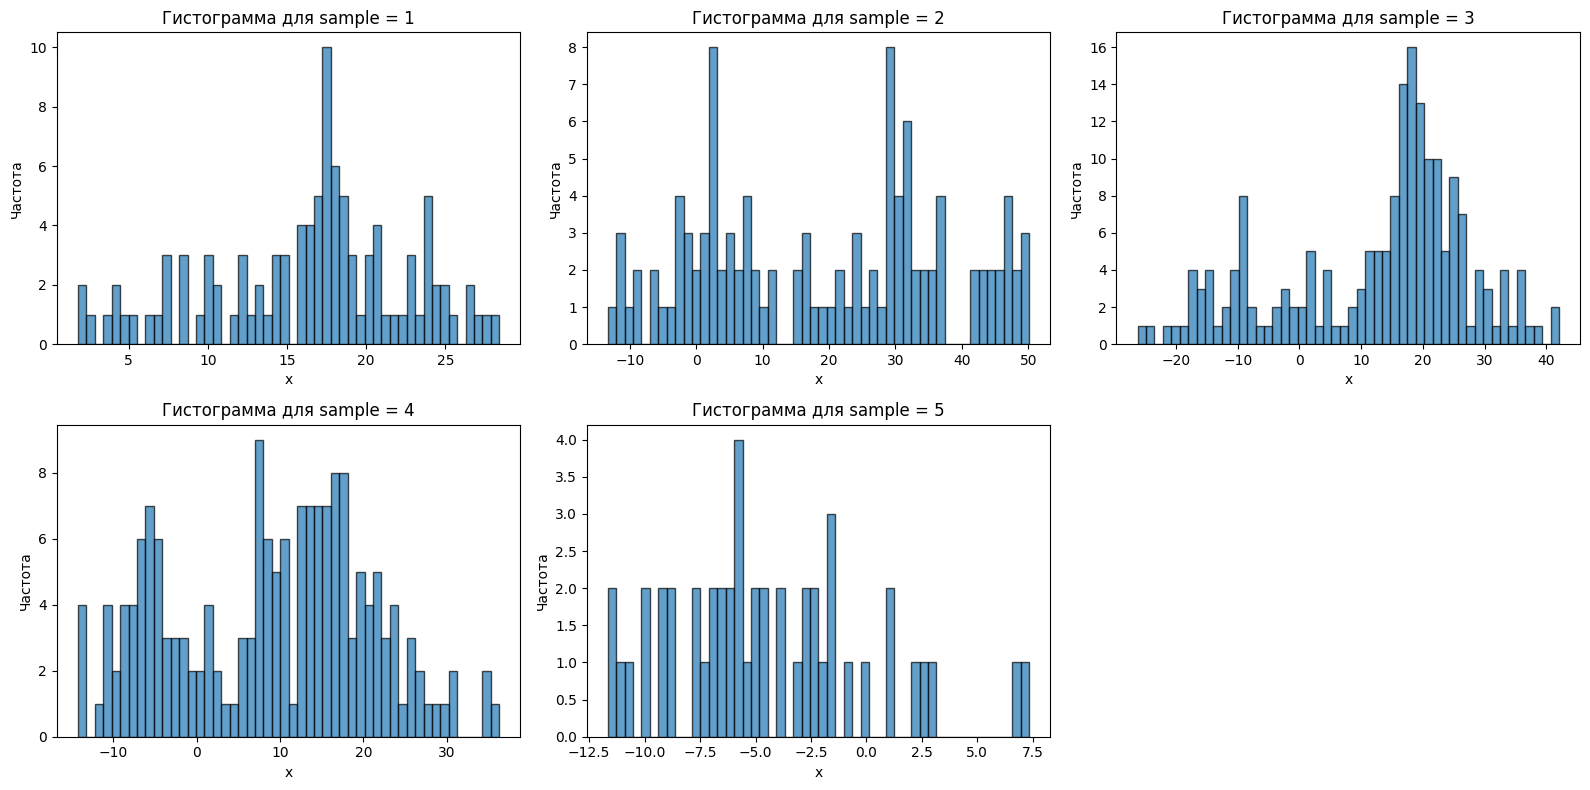

In [7]:
draw_hists(mean_1,50)

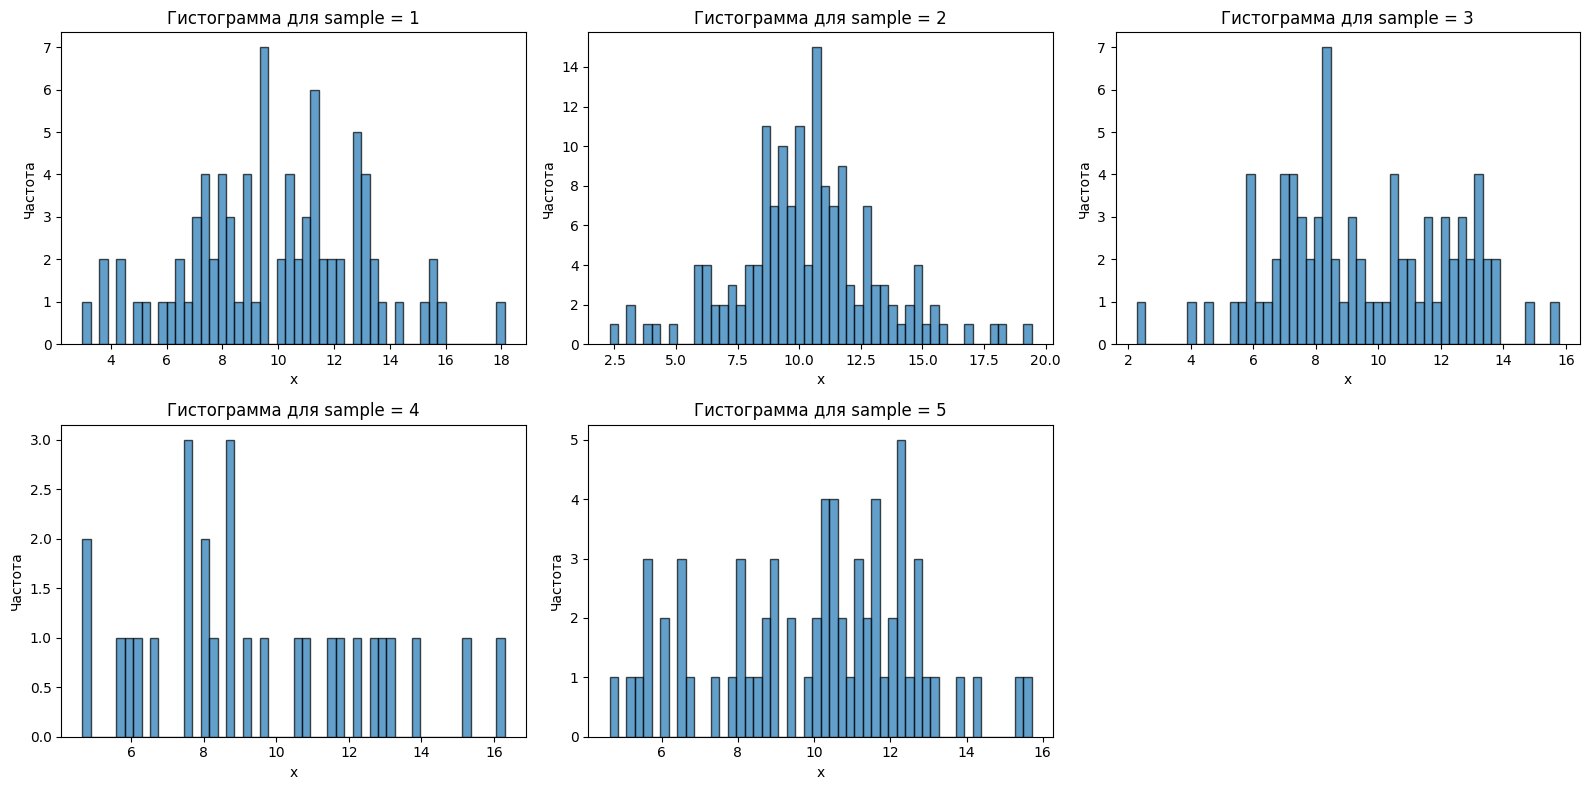

In [14]:
draw_hists(mean_2,50)

In [15]:
mu1 = mean_1.groupby('sample')['x'].mean().reset_index().mean()['x'] #Сильнозависимый 
mu2 = mean_2['x'].mean()

print("mu1=",mu1)
print("mu2=",mu2) 



mu1= 10.50905895088439
mu2= 9.965079864738108


# Теперь с $\eta$ работаем 

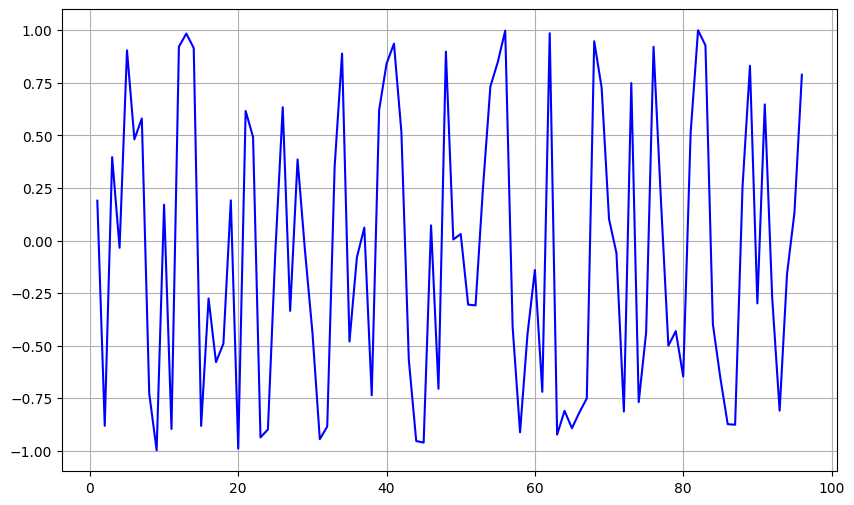

In [16]:
periodic = pd.read_csv('periodic.csv')
# Построение графика x от t
plt.figure(figsize=(10, 6))
plt.plot(periodic['t'], periodic['x'], label='x от t', color='blue')
plt.grid(True)
plt.show()

Исторически ложилось, что получилась функция для автокореляции

[ 1.          0.1800488  -0.08083702 -0.30328442 -0.37494633 -0.15225021
  0.17372088  0.34872548  0.18333437 -0.0433624  -0.51512411 -0.33117747
  0.00507096  0.22414214  0.41877378  0.23127738 -0.0589356  -0.38986
 -0.28594871 -0.13041347  0.34546648  0.31210076  0.09042612 -0.04678469
 -0.50816491 -0.3482155  -0.053649    0.42887297  0.36911169  0.26104453
 -0.19879095 -0.4408245  -0.2793292  -0.08206901  0.39112218  0.29636747
  0.23066744 -0.20730523 -0.44512438 -0.30236425  0.10848131  0.33519981
  0.35612603  0.4211413  -0.24320386 -0.39510666 -0.29375373  0.04129265
  0.32488834  0.33780991  0.16412176 -0.2887483  -0.25037562 -0.51158651
  0.03073522  0.52176809  0.28451945  0.15962978 -0.32336194 -0.27934095
 -0.31951535  0.04870516  0.1364026   0.42830894  0.01497584 -0.26307398
 -0.20973178 -0.14827287  0.02189462  0.34354461  0.53343972 -0.12215947
 -0.27188791 -0.41191205 -0.42291037  0.18191782  0.38737001  0.45314437
  0.27195413 -0.17030481 -0.69758587 -0.46980258  0.19

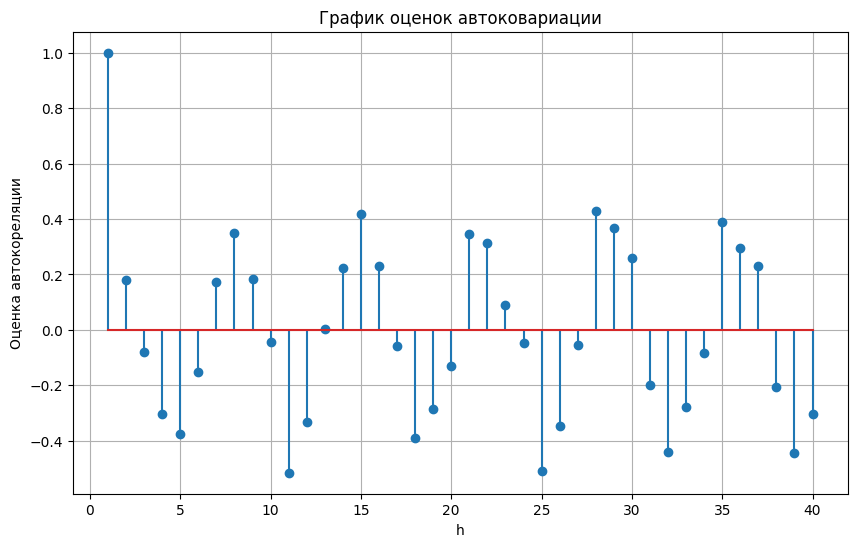

In [105]:
def estimate_autocovariance(D,h):
    sum_terms = 0
    count = 0
    for i in range(len(D)):
        X_i = np.array(D[i])
        n_i = X_i.size
        for j in range(n_i - h):
            sum_terms += (X_i[j] - X_i.mean()) * (X_i[j + h] - X_i.mean())
            count += 1
    gamma_h = (1 / count) * sum_terms
    return gamma_h

def estimate_autocovariance_vector(D, X):
    D = np.array(D)
    gamma_0 = estimate_autocovariance(D,0)

    gamma_h_vec = np.zeros(X.size)

    for h in range(X.size):
        gamma_h_vec[h] = estimate_autocovariance(D,h)
    return gamma_h_vec/gamma_0

gamma_h = estimate_autocovariance_vector([periodic['x']],periodic['x'])
print(f"{gamma_h}")

plt.figure(figsize=(10, 6))
plt.stem(periodic['t'][:40], gamma_h[:40])
# plt.plot(periodic['t'], gamma_h, marker='o', linestyle='-', color='b')
plt.title('График оценок автоковариации')
plt.xlabel('h')
plt.ylabel('Оценка автокореляции')
plt.grid(True)
plt.show()


Воспользуемся встроенной функцией для автокореляции

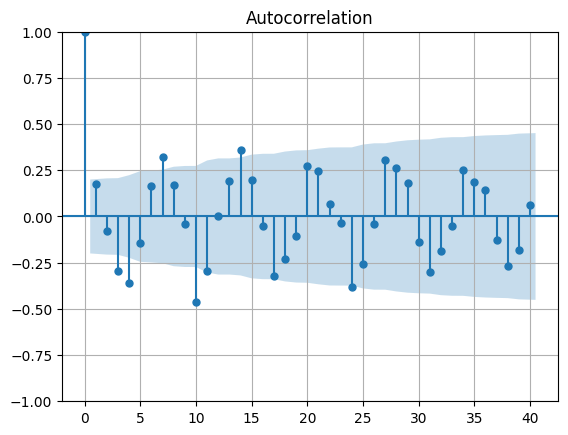

In [59]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(periodic['x'], lags=40) 
plt.grid(True)
plt.show()

Судя по графику, период равен 7, так как разница между пиками в большинстве случаев = 7

# Теперь с $\alpha$ и $\beta$ работаем


In [109]:
cross = pd.read_csv('cross.csv')

In [130]:
cross.shape

(91, 3)

In [236]:
def cross_covariance(x, y, max_lag):
    x = np.array(x)
    y = np.array(y)

    # Вычисляем математические ожидания
    mu_x = np.mean(x)
    mu_y = np.mean(y)

    # Вычисляем центрированные временные ряды
    x_centered = x - mu_x
    y_centered = y - mu_y

    # Вычисляем кросс-ковариацию
    lags = np.arange(-max_lag, max_lag + 1)
    cross_cov = np.array([np.sum(x_centered[:len(x)-lag] * y_centered[lag:]) if lag >= 0 else np.sum(x_centered[-lag:] * y_centered[:len(y)+lag]) for lag in lags])

    return lags, cross_cov

lags, cross_cov = cross_covariance(cross['x'],cross['y'],6)

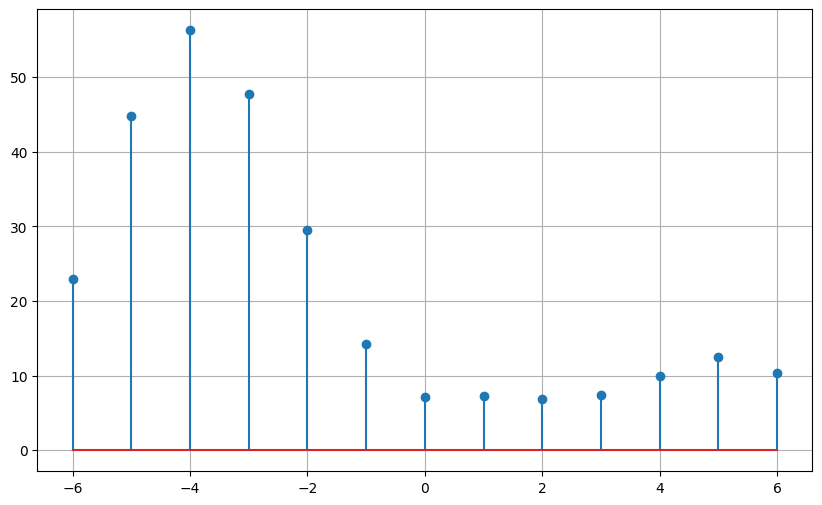

In [237]:
plt.figure(figsize=(10, 6))
plt.stem(lags,cross_cov)
plt.grid(True)
plt.show()

Получается при -4, достигается максимальная ковариация

А теперь Выясним смещение Империческим Путём! 

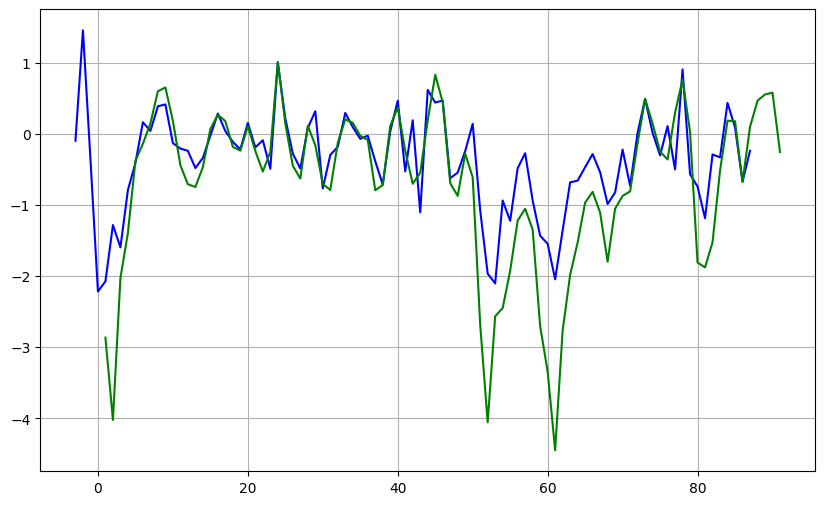

In [216]:

cross_cut = cross
cross_cut['t_shifted'] = cross_cut['t'] - 4

plt.figure(figsize=(10, 6))
plt.plot(cross_cut['t_shifted'], cross_cut['x'], label='x от t', color='blue')
plt.plot(cross_cut['t'], cross_cut['y'], label='y от t', color='green')
plt.grid(True)
plt.show()

Можем в этом убедиться наглядно ! 